# Authentication

Django has an authentication system available under `django.contrib.auth` which includes

 * `User` model to store user authentication information. 
   `from django.contrib.auth.models import User`
 * Methods to authenticate, create session, destroy session for user
   `from django.contrib.auth import authenticate, login, logout`
 * Passes user information in `HttpRequest` object in `user` field.
 * Model based permissions as `request.user.has_perms('appname.add_modelname')`
 * Decorators for typical authentication/authorization checks
   `from django.contrib.auth.decorators import login_required,permission_required`
   
```python
   @login_required
   def index(request):
     ....
```
 * Default views for login/logout/password change and other routine tasks and their default forms. You need to include them in `urls.py`
   `url(r'^accounts/', include('django.contrib.auth.urls')`
 
## Authentication Use Case


   

In [2]:
%load_ext diagmagic

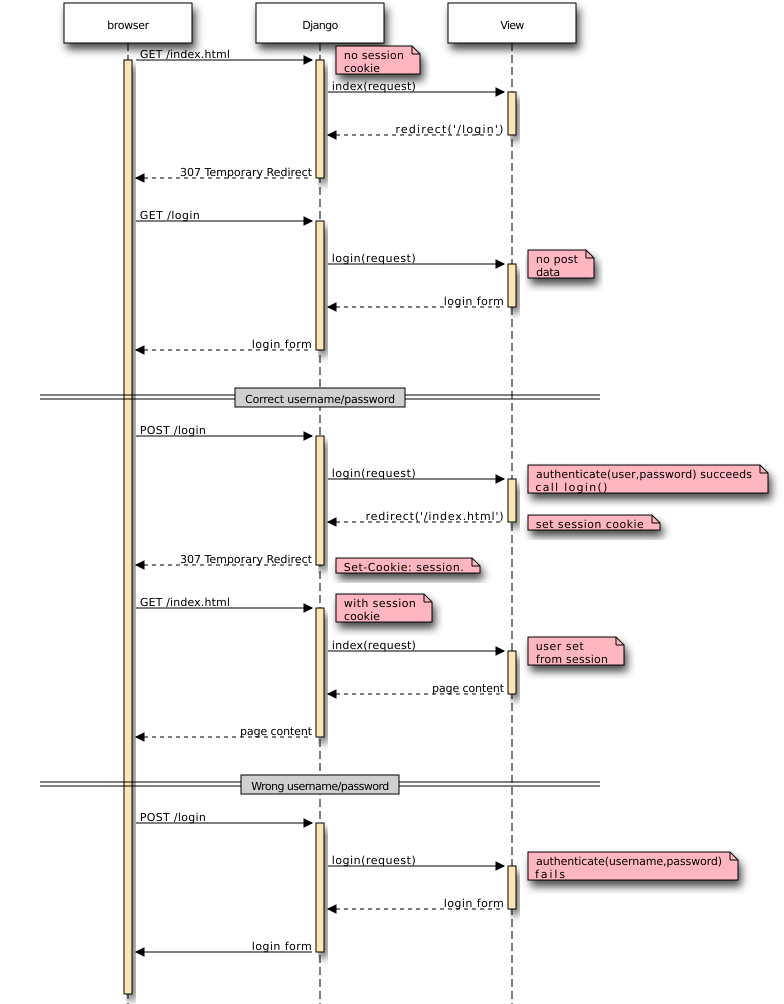

In [3]:
%%seqdiag
seqdiag {
    span_height = 3;
    browser -> Django [ label = "GET /index.html", note="no session\ncookie"];
    Django -> View [ label = "index(request)"];
    Django <-- View  [ label= "redirect('/login')" ];
    browser <-- Django [label = "307 Temporary Redirect" ];
    browser -> Django [label = "GET /login"];
    Django -> View [ label = "login(request)", note="no post\ndata"];
    Django <-- View [ label = "login form"];
    browser <-- Django [ label = "login form"];
     === "Correct username/password" ===
    browser -> Django [ label = "POST /login" ];
    Django -> View [ label = "login(request)", note="authenticate(user,password) succeeds\ncall login()"];
    Django <-- View [ label = "redirect('/index.html')",note="set session cookie"];
    browser <-- Django [ label = "307 Temporary Redirect", note="Set-Cookie: session."];
    browser -> Django [ label = "GET /index.html", note="with session\ncookie"];
    Django -> View [ label = "index(request)", note="user set\nfrom session"];
    Django <-- View [ label = 'page content'];
    browser <-- Django [ label = 'page content']
    === "Wrong username/password" ===
    browser -> Django [ label = "POST /login" ];
    Django -> View [ label = "login(request)", note="authenticate(username,password)\nfails"];
    Django <-- View [ label = "login form"];
    browser <- Django [ label = "login form"];
}

Django authentication middleware and `@login_required` decorator implements first part of this scenario. Each request is checked against if session is set automatically by the authentication middleware and middleware sets `request.user` to a valid user or `AnonymousUser`. `request.user.is_authenticated` gives a boolean value. `@login_required` decorator checks this value and return redirect to a login view.

Second step is to write a login view that will show login form initially, then when posted check authentication and create session. A typical login view:
```python
from django.contrib.auth import  authenticate,login,logout
from django.contrib.auth.decorators import login_required
from django.contrib.auth.forms import AuthenticationForm
def login(request):
    if 'username' in request.POST and 'password' in request.POST:
        username = request.POST['username']
        password = request.POST['password']
        user = authenticate(request, username=username, password=password)
        if user is not None:
            login(request, user)   # this sets the session, 
            # Redirect to a success page.
            ...
        else:
            # Return an 'invalid login' error message.
            ...
    else:    # first time, return the login page
        return render('login.html', {'form': AuthenticationForm})
```
Logging out is simply:
```python
def logout_view(request):
    logout(request)
    # Redirect to a success page.
```

## Authentication form

`django.contrib.auth.forms` include standard fonts like password authentication, password change, password reset etc. This forms implement HTML representation of forms and their validation. You can use them in a template (assume `form` contains such a form):

```python
<h1> Login Page </h1>
You are not authenticated to access this page
<form method="post">
{% csrf_token %}
{{ form.as_p }}
<input type="hidden" name="next" value="{{ next }}" />
<input type="submit" name="submit" value="Login"/>
</form>
```
`form.as_p()` and `form.as_table()` returns the HTML representations of the form.

## Authentication views

Adding the following include statement in project `urls.py` includes default views of authentication framework:
```python
url(r'^accounts/', include('django.contrib.auth.urls'))
```
`login, logout, password_change, password_reset` are defined in this include. They look for some templates, otherwise provide full authentication mechanism. `login` requires `registration/login.html` template. Remaining tasks are handled.

## Authentication and Models
Most application have user dependency. For example each student updates only his/her student record. A online shopping application has users orders, shopping basket. A content management application has pages owned by different users. A webmail application does most of its job in the IMAP service however user preferences has to be kept in a database.

In order to represent this dependency, data models should be related to the django  authentication. `django.contrib.auth.models` have `User, Group, Permission` models. Application models can refer this models to define dependencies. For example models:
```python
from django.db import models
from django.contrib.auth.models import User

class Preferences(models.Model):
    # ...
    user = models.OneToOneField(User)
    #...

class BasketEntry(models.Model):
    item = models.ForeignKey(ShopItem)
    count = models.PositiveIntegerField()
    price = models.DecimalField(decimal_places=2)
    user = models.ForeignKey(User)
```
Each `User` has a `Preferences`. `request.user.preferences` will give it. Each `User` has a list of `BasketEntry`. `request.user.basketentry_set.all()` will return them.

## Crypt module

In [ ]:
import crypt